In [1]:
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
from keras.models import Sequential
from keras.metrics import F1Score
from sklearn.metrics import auc, roc_curve
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from keras_tuner import RandomSearch
import pickle
import numpy as np
import seaborn as sns
import shap

In [ ]:
df_dict = {
    'all': {},
    'CDS': {},
    'CAT': {}
}
df_dict['all']['X_train'] = pd.read_csv('train/X_train.csv')
df_dict['all']['y_train'] = pd.read_csv('train/y_train.csv')
df_dict['all']['X_test'] = pd.read_csv('test/X_test.csv')
df_dict['all']['y_test'] = pd.read_csv('test/y_test.csv')
df_dict['CDS']['X_train'] = df_dict['all']['X_train'].iloc[:,18:]
df_dict['CDS']['y_train'] = df_dict['all']['y_train']
df_dict['CDS']['X_test'] = df_dict['all']['X_test'].iloc[:,18:]
df_dict['CDS']['y_test'] = df_dict['all']['y_test']
df_dict['CAT']['X_train'] = pd.read_csv('train/X_train_cat.csv')
df_dict['CAT']['y_train'] = pd.read_csv('train/y_train_cat.csv')
df_dict['CAT']['X_test'] = pd.read_csv('test/X_test_cat.csv')
df_dict['CAT']['y_test'] = pd.read_csv('test/y_test_cat.csv')

In [ ]:
class NNResults:
    def __init__(self, clf, y_pred, f1, acc_anxiety, acc_depression, model_name, rows, X_test, y_test, best_hp, history, col_names):
        self.clf = clf
        self.y_pred = y_pred
        self.f1 = f1
        self.acc_anxiety = acc_anxiety
        self.acc_depression = acc_depression
        self.name = model_name
        self.rows = rows
        self.X_test = X_test
        self.y_test = y_test
        self.best_hp = best_hp
        self.history = history
        self.col_names = col_names

class NeuralNetworkTrainer:
    def __init__(self, input_shape):
        self.input_shape = input_shape


    def build_model(self, hp):
         # Hyperparameters to test
        optimizer = hp.Choice('optimizer', ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
        model = Sequential()
        model.add(Input(shape=(self.input_shape,)))
        model.add(Dense(128, 
                        activation=hp.Choice('activation1', ['relu', 'leaky_relu', 'tanh'])))
        model.add(Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))
        model.add(Dense(64, 
                        activation=hp.Choice('activation2', ['relu', 'leaky_relu', 'tanh'])))
        model.add(Dense(2, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',F1Score(average='macro')])
        return model

    def preprocess_data(self, X_train, X_test):
            # Create a pipeline to apply StandardScaler and then Normalizer
        scaler = StandardScaler()
        normalizer = Normalizer()

        pipeline = Pipeline([
            ('scaler', scaler),
            ('normalizer', normalizer)
        ])
        
        # Assuming X is your input data
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        return X_train, X_test, pipeline
    
    
    def train_and_evaluate(self, X_train, y_train, X_test, y_test, model_name, use_sample_weight=False):
        tuner = RandomSearch(
            hypermodel=self.build_model,
            objective=kt.Objective('val_f1_score', direction='max'),
            max_trials=10,
            overwrite=True,
            directory="NN_models",
            project_name=model_name
        )
        # Preprocess the data
        col_names = X_train.columns
        X_train, X_test, pipeline = self.preprocess_data(X_train, X_test)
        pickle.dump(pipeline, open(f'models/{model_name}_pipeline.pkl', 'wb'))
        
        # Define the early stopping callback
        early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_f1_score')

        anxiety_counts = y_train['group_anxiety'].value_counts()
        depression_counts = y_train['group_depression'].value_counts()
        # Total number of samples
        n_samples = len(y_train)

        # Anxiety
        anxiety_weight_0 = n_samples / (2 * anxiety_counts[0])
        anxiety_weight_1 = n_samples / (2 * anxiety_counts[1])

        # Depression
        depression_weight_0 = n_samples / (2 * depression_counts[0])
        depression_weight_1 = n_samples / (2 * depression_counts[1])
        
        # Initialize
        sample_weight = np.ones(n_samples)

        # For each sample, multiply the weights
        for i in range(n_samples):
            anxiety_label = y_train.iloc[i]['group_anxiety']
            depression_label = y_train.iloc[i]['group_depression']
            
            # Get corresponding weights
            a_weight = anxiety_weight_0 if anxiety_label == 0 else anxiety_weight_1
            d_weight = depression_weight_0 if depression_label == 0 else depression_weight_1
            # Multiply both
            if use_sample_weight:
                sample_weight[i] = a_weight * d_weight
            else:
                sample_weight = None
        

        tuner.search(
            X_train, y_train,
            epochs=50,
            batch_size=10,
            validation_split=0.2,
            callbacks=[early_stopping],
            sample_weight=sample_weight,
            verbose=0
        )

        # Get best hyperparameters
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

        # Rebuild the model with best hyperparameters
        final_model = self.build_model(best_hp)

        # Train on the full training data (no validation split this time)
        final_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        # Predict on test set
        y_pred = final_model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)

        # Compute metrics
        f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
        acc_anxiety = round(accuracy_score(y_test.iloc[:, 0], y_pred[:, 0]), 3)
        acc_depression = round(accuracy_score(y_test.iloc[:, 1], y_pred[:, 1]), 3)
        
        # Get the best hyperparameters
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
            
        final_model.save(f'models/{model_name}_best_model.keras')
        history = final_model.fit(X_train, y_train, epochs=50, batch_size=25, verbose=0, validation_split=0.2)

        # Return results
        return NNResults(final_model, y_pred, f1, acc_anxiety, acc_depression, model_name, X_test.shape[0], X_test, y_test, best_hp, history, col_names)

In [79]:
# Store results
all_results = {}

for subset_name, data in df_dict.items():
    print(f"Training model for subset: {subset_name}")
    
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    trainer = NeuralNetworkTrainer(input_shape=X_train.shape[1])

    nn_result = trainer.train_and_evaluate(X_train, y_train, X_test, y_test, model_name=f"NN_{subset_name}", use_sample_weight=True)

    # Store results by subset name
    all_results[subset_name] = nn_result

for subset, result in all_results.items():
    print(f"Results for {subset}: F1 = {result.f1}, Anxiety Acc = {result.acc_anxiety}, Depression Acc = {result.acc_depression}")

Training model for subset: all
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training model for subset: CDS
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training model for subset: CAT
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Results for all: F1 = 0.647, Anxiety Acc = 0.571, Depression Acc = 0.558
Results for CDS: F1 = 0.691, Anxiety Acc = 0.567, Depression Acc = 0.601
Results for CAT: F1 = 0.737, Anxiety Acc = 0.591, Depression Acc = 0.623


In [80]:
import matplotlib.pyplot as plt

def summarize_diagnostics(history, title=None):
    plt.figure(figsize=(10, 4))
    if title:
        plt.suptitle(title, fontsize=14, y=1.05)
        
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.title('Binary Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history.get('val_loss', []), color='orange', label='validation')
    plt.legend()

    # Plot Accuracy or F1-score if available
    plt.subplot(1, 2, 2)
    if 'f1_score' in history.history:
        plt.title('F1 Score')
        plt.plot(history.history['f1_score'], color='blue', label='train')
        plt.plot(history.history.get('val_f1_score', []), color='orange', label='validation')
    else:
        plt.title('Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history.get('val_accuracy', []), color='orange', label='validation')
        
    plt.legend()
    plt.show()

In [153]:
for subset, result in all_results.items():
    print(f"Results for {subset}:")
    print(classification_report(result.y_test, result.y_pred, zero_division=0, target_names=y_train.columns.values))
    test_accuracy = accuracy_score(result.y_test, result.y_pred)
    print(f"Test Set Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy anxiety: {result.acc_anxiety:.4f}")
    print(f"Accuracy depression: {result.acc_depression:.4f}")
    print('\n')

Results for all:
                  precision    recall  f1-score   support

   group_anxiety       0.65      0.62      0.63       278
group_depression       0.63      0.69      0.66       290

       micro avg       0.64      0.65      0.65       568
       macro avg       0.64      0.65      0.65       568
    weighted avg       0.64      0.65      0.65       568
     samples avg       0.63      0.64      0.61       568

Test Set Accuracy: 0.4246
Accuracy anxiety: 0.5710
Accuracy depression: 0.5580


Results for CDS:
                  precision    recall  f1-score   support

   group_anxiety       0.62      0.72      0.67       278
group_depression       0.65      0.80      0.71       290

       micro avg       0.63      0.76      0.69       568
       macro avg       0.63      0.76      0.69       568
    weighted avg       0.63      0.76      0.69       568
     samples avg       0.64      0.76      0.66       568

Test Set Accuracy: 0.3513
Accuracy anxiety: 0.5670
Accuracy depress

In [82]:
# import pandas as pd

summary = {
    'Subset': [],
    'F1-score': [],
    'Accuracy - Anxiety': [],
    'Accuracy - Depression': []
}

for subset, result in all_results.items():
    summary['Subset'].append(subset)
    summary['F1-score'].append(result.f1)
    summary['Accuracy - Anxiety'].append(result.acc_anxiety)
    summary['Accuracy - Depression'].append(result.acc_depression)

df_summary = pd.DataFrame(summary)
df_summary

,Subset,F1-score,Accuracy - Anxiety,Accuracy - Depression
0,all,0.647,0.571,0.558
1,CDS,0.691,0.567,0.601
2,CAT,0.737,0.591,0.623


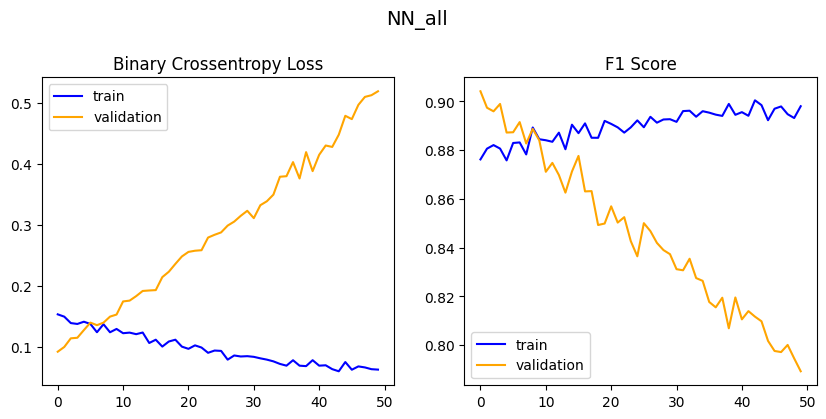

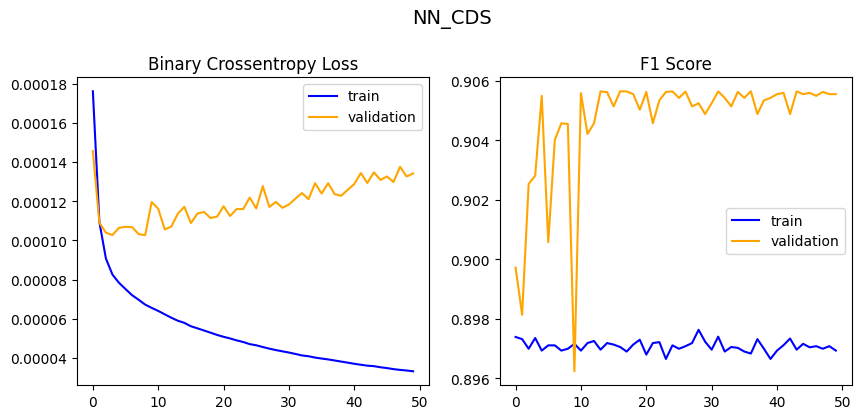

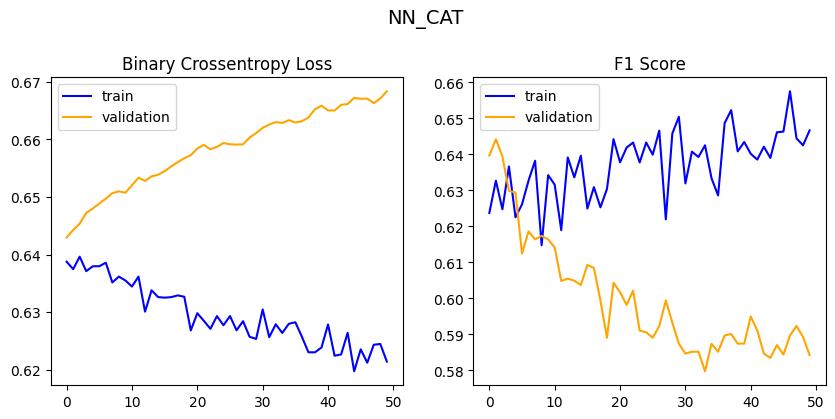

In [83]:
for result in all_results.values():
    summarize_diagnostics(result.history, title=result.name)

In [84]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# Function to plot ROC curves per label per subset
def plot_roc_curves(all_results, label_names=['Anxiety', 'Depression']):
    plt.figure(figsize=(12, 6))

    # Separate plots for Anxiety and Depression
    for i, label in enumerate(label_names):
        plt.subplot(1, 2, i+1)
        plt.title(f'ROC Curve - {label}')
        
        for subset, result in all_results.items():
            # Predict probabilities again (y_pred_proba)
            y_proba = result.clf.predict(result.X_test)  # result.X_test needs to be saved in NNResults
            
            if isinstance(y_proba, list):
                y_proba = y_proba[0]  # For Keras predict returning list

            fpr, tpr, _ = roc_curve(result.y_test.iloc[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{subset} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


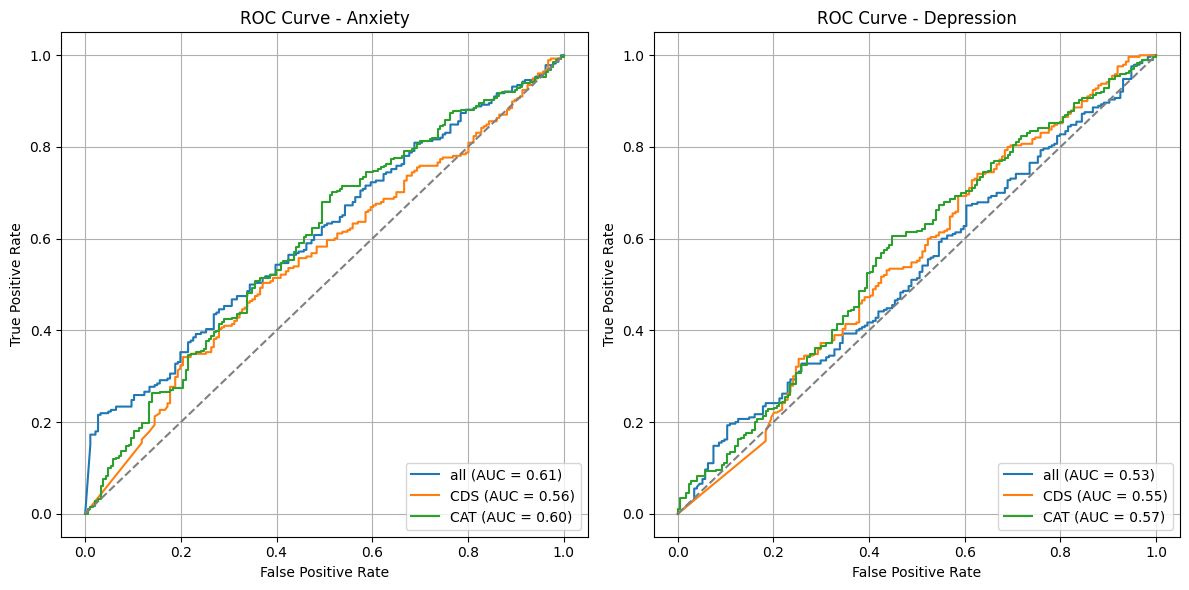

In [85]:
plot_roc_curves(all_results, label_names=['Anxiety', 'Depression'])

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# Plot confusion matrices for all subsets and both labels
def plot_confusion_matrices(all_results, label_names=['Anxiety', 'Depression']):
    num_subsets = len(all_results)
    fig, axes = plt.subplots(num_subsets, 2, figsize=(10, 4 * num_subsets))
    
    if num_subsets == 1:
        axes = [axes]  # Ensure iterable shape consistency if only 1 subset
    
    for row_idx, (subset, result) in enumerate(all_results.items()):
        for col_idx, label in enumerate(label_names):
            ax = axes[row_idx][col_idx] if num_subsets > 1 else axes[0][col_idx]

            # Confusion Matrix
            cm = confusion_matrix(result.y_test.iloc[:, col_idx], result.y_pred[:, col_idx])
            # cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                        xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
            accuracy = np.trace(cm) / np.sum(cm)
            ax.set_title(f"{subset} - {label}: Acc = {accuracy:.2f}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

all - Anxiety Accuracy 0.571
all - Depression Accuracy 0.558
CDS - Anxiety Accuracy 0.567
CDS - Depression Accuracy 0.601
CAT - Anxiety Accuracy 0.591
CAT - Depression Accuracy 0.623


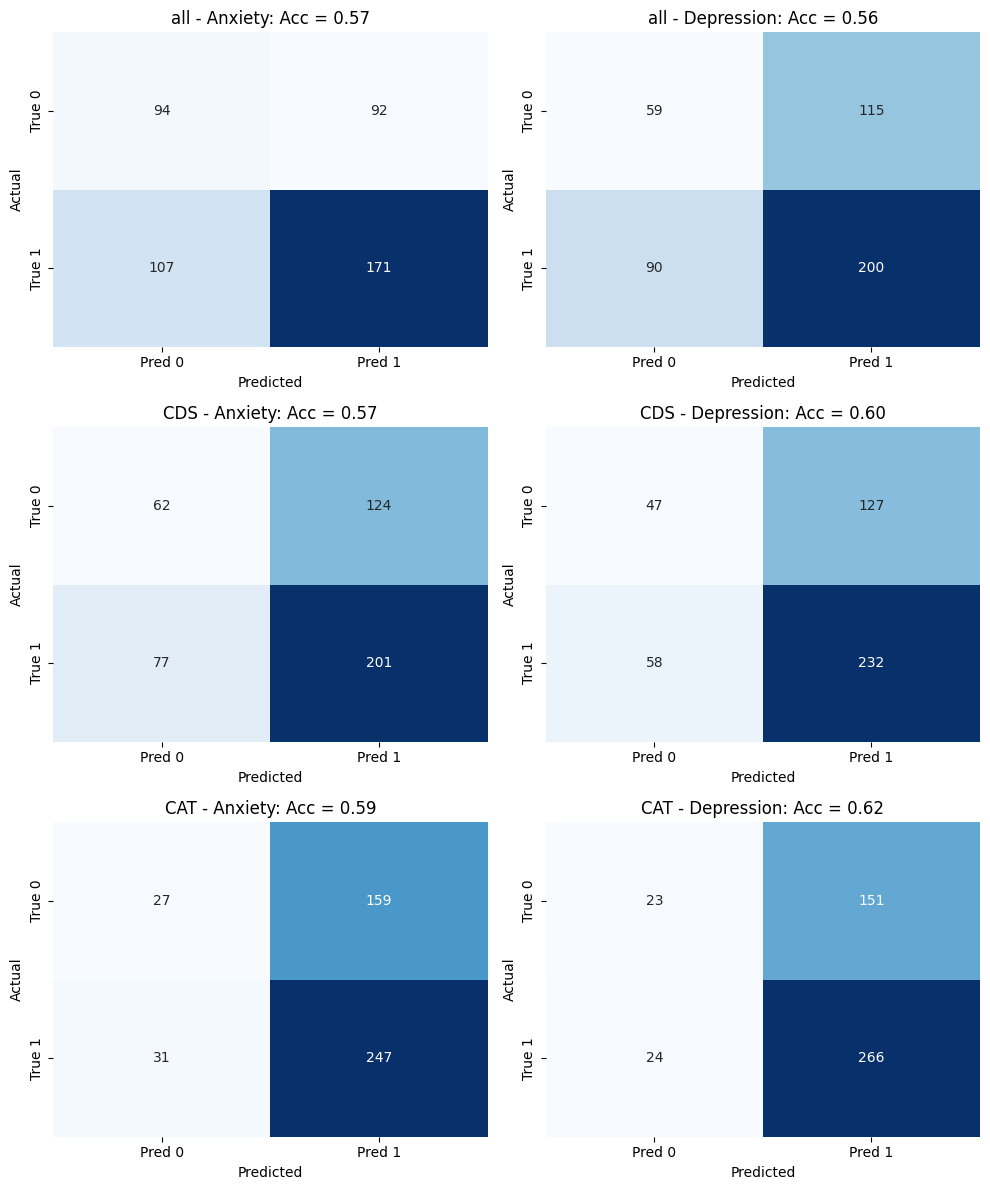

In [151]:
plot_confusion_matrices(all_results, label_names=['Anxiety', 'Depression'])

In [88]:
for subset, result in all_results.items():
    print(f"Subset: {subset}")
    print(f"Best Hyperparameters: {result.best_hp.values}")
    print("\n")

Subset: all
Best Hyperparameters: {'optimizer': 'Adam', 'activation1': 'tanh', 'dropout': 0.4, 'activation2': 'relu'}


Subset: CDS
Best Hyperparameters: {'optimizer': 'RMSprop', 'activation1': 'relu', 'dropout': 0.0, 'activation2': 'leaky_relu'}


Subset: CAT
Best Hyperparameters: {'optimizer': 'Adamax', 'activation1': 'leaky_relu', 'dropout': 0.4, 'activation2': 'relu'}




In [131]:
# print the JS visualization code to the notebook
import warnings
from sklearn.exceptions import ConvergenceWarning
subset = 'CAT'
result = all_results[subset]
# Create the list of all labels for the drop down list
list_of_labels = result.y_test.columns.to_list()
shap_dict = {}

background = shap.kmeans(result.X_test, 50)  # Cluster into 100 centroid
explainer = shap.KernelExplainer(result.clf.predict, background)

for label in list_of_labels:
    # Suppress only ConvergenceWarnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        shap_dict[label] = explainer(result.X_test)
    print(f"Current Label Shown: {label}\n")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  0%|          | 0/464 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 293us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step
1/1 

  0%|          | 0/464 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 228us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
1/1 

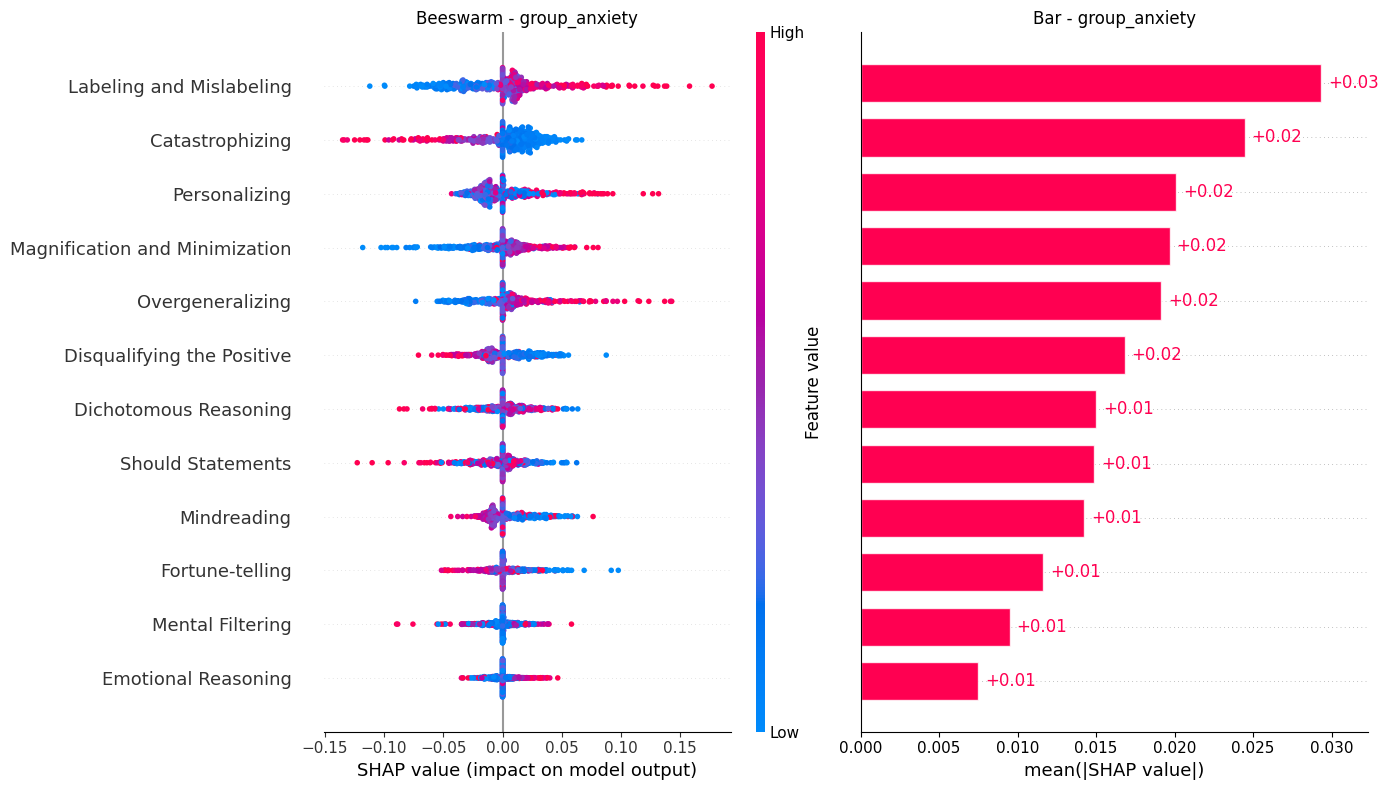

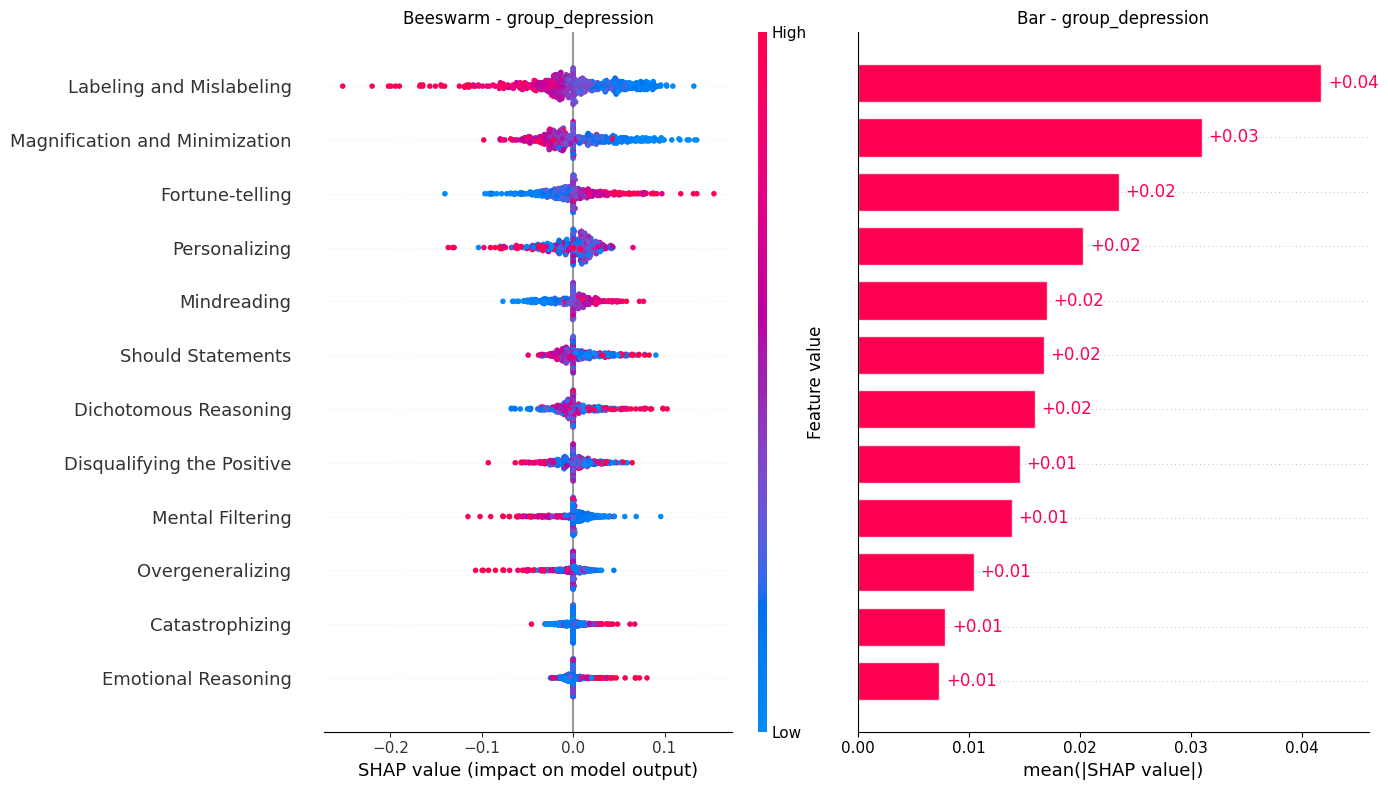

In [133]:
for i, (key, value) in enumerate(shap_dict.items()):
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))  # Wider plot
    value.feature_names = result.col_names
    # Beeswarm on first axis
    shap.plots.beeswarm(
        value[:, :, i],
        show=False,
        ax=axs[0],
        max_display=20,
        plot_size = None
    )
    axs[0].set_title(f"Beeswarm - {key}")

    # Bar on second axis
    shap.plots.bar(
        value[:, :, i],
        show=False,
        ax=axs[1],
        max_display=20
    )
    axs[1].yaxis.set_visible(False)
    # axs[1].figure.set_size_inches(20, 8)
    axs[1].set_title(f"Bar - {key}")

    plt.tight_layout()
    plt.show()

1


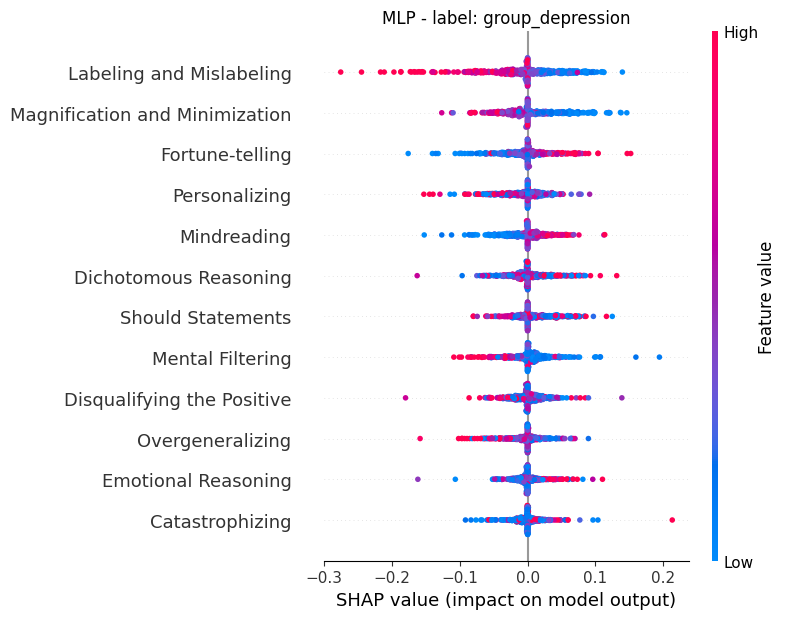

In [103]:
shap.initjs()
print(current_label.value)
shap.summary_plot(shap_values=shap_values[:, :, current_label.value], features=result.X_test, feature_names=result.col_names, show=False)
plt.title(f"MLP - label: {list_of_labels[current_label.value]}")
plt.tight_layout()
plt.show()